# Horizon finding

Finding apparent horizons can be used for

* physical information (analysis);
* adapting the grid (AMR);
* gauge conditions (moving punctures);

and so on.

This is a *boundary value problem*.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
def horizon_RHS(H, theta, z_singularities):
    """
    The RHS function for the apparent horizon problem.
    
    Parameters
    ----------
    
    H : array
        vector [h, dh/dtheta]
    theta : double
        angle
    z_singularities : array
        Location of the singularities on the z axis; non-negative
    
    Returns
    -------
    
    dHdtheta : array
        RHS
    """
    
    assert(numpy.all(numpy.array(z_singularities) >= 0.0)), "Location of singularities cannot be negative"
    
    h = H[0]
    dh = H[1]
    
    psi = 1.0
    dpsi_dr = 0.0
    dpsi_dtheta = 0.0
    for z in z_singularities:
        distance = numpy.sqrt((h*numpy.sin(theta))**2 + (h*numpy.cos(theta) - z)**2)
        psi += 0.5/distance
        dpsi_dr -= 0.5*(h-z*numpy.cos(theta))/distance**3
        dpsi_dtheta -= 0.5**h*z*numpy.sin(theta)/distance**3
        # Apply reflection symmetry
        if z > 0.0:
            distance = numpy.sqrt((h*numpy.sin(theta))**2 + (h*numpy.cos(theta) + z)**2)
            psi += 0.5/distance
            dpsi_dr -= 0.5*(h+z*numpy.cos(theta))/distance**3
            dpsi_dtheta += 0.5**h*z*numpy.sin(theta)/distance**3
            

    C2 = 1.0 / (1.0 + (dh / h)**2)
    # Impose that the term involving cot(theta) vanishes on axis.
    if (abs(theta) < 1e-16) or (abs(theta - numpy.pi) < 1e-16):
        cot_theta_dh_C2 = 0.0
    else:
        cot_theta_dh_C2 = dh / (numpy.tan(theta) * C2)
        
    dHdtheta = numpy.zeros_like(H)
    dHdtheta[0] = dh
    dHdtheta[1] = 2.0*h - cot_theta_dh_C2 + 4.0*h**2/(psi*C2)*(dpsi_dr - dpsi_dtheta*dh/h**2) + 3.0*dh**2/h
    
    return dHdtheta

## Axisymmetry

We'll assume all masses are $1$, conformal flatness, time symmetry, axisymmetry and bitant symmetry.

Using horizon radius $h(\theta)$, ${\bf H} = (h, h')^T$, problem is

\begin{align}
  \frac{d}{d \theta} {\bf H} &= {\bf F}({\bf H}, \theta) = \begin{pmatrix} H_2 \\ 2 H_1 + \frac{3}{H_1} H_2^2 + f(\theta, {\bf H}) \end{pmatrix}, \\ H_2(\theta = 0) &= 0 = H_2(\theta = \pi/2).
\end{align}

## Euler's method

Assume we know $H_1(0)$: an initial value problem.

Apply forward differencing to derivative:

\begin{align}
  && \left. \frac{d}{d \theta} {\bf H} \right|_{\theta = \theta_i} & \approx \frac{1}{\Delta \theta} \left( {\bf H}^{(i+1)} - {\bf H}^{(i)} \right) \\
  && & = {\bf F}({\bf H}^{(i)}, \theta_i), \\
  \implies && {\bf H}^{(i+1)} &= {\bf H}^{(i)} + \Delta \theta \, {\bf F}({\bf H}^{(i)}, \theta_i).
\end{align}

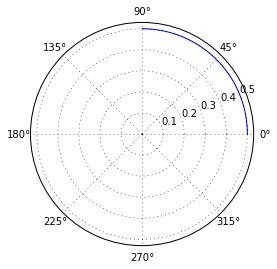

In [3]:
def euler_step(Hi, theta_i, dtheta, z_singularity):
    return Hi + dtheta * horizon_RHS(Hi, theta_i, 
                                   z_singularity)

Ntheta = 100
z_singularity = [0.0]
theta = numpy.linspace(0.0, numpy.pi/2.0, Ntheta)
dtheta = theta[1] - theta[0]
H = numpy.zeros((2, Ntheta))
H[:, 0] = [0.5, 0.0]

for i in range(Ntheta-1):
    H[:, i+1] = euler_step(H[:, i], theta[i], dtheta, 
                           z_singularity)

pyplot.figure()
pyplot.polar(theta, H[0,:])
pyplot.show()

## Runge-Kutta method

Euler's method is first order (poor). Instead combine *multiple* Euler steps: Runge-Kutta methods. 

A second order method is

\begin{align}
  {\bf H}^{(p)} &= {\bf H}^{(i)} + \Delta \theta \, {\bf F}({\bf H}^{(i)}, \theta_i), \\
  {\bf H}^{(i+1)} &= \frac{1}{2} \left( {\bf H}^{(i)} + {\bf H}^{(p)} + \Delta \theta \, {\bf F}({\bf H}^{(p)}, \theta_{i+1}) \right).
\end{align}

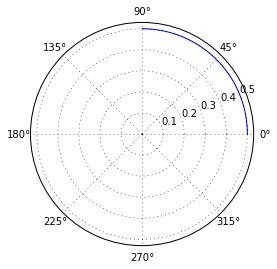

In [4]:
def rk2_step(Hi, theta_i, dtheta, z_singularity):
    Hp = Hi + dtheta * horizon_RHS(Hi, theta_i,
                                   z_singularity)
    return 0.5*(Hi + Hp + 
                dtheta*horizon_RHS(Hp, theta_i+dtheta,
                                   z_singularity))

H = numpy.zeros((2, Ntheta))
H[:, 0] = [0.5, 0.0]

for i in range(Ntheta-1):
    H[:, i+1] = rk2_step(H[:, i], theta[i], dtheta,
                         z_singularity)

pyplot.figure()
pyplot.polar(theta, H[0,:])
pyplot.show()

## Root finding

If we don't know $h(0)$ we need to find it. Method:

1. Guess;
2. Solve for ${\bf H}$;
3. Check boundary condition for $H_2(\pi/2)$;
4. Change guess and go to 2.

This is a nonlinear root-finding problem.

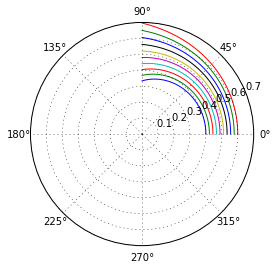

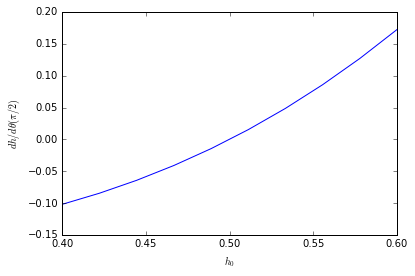

In [5]:
initial_guesses = numpy.linspace(0.4, 0.6, 10)
solutions = []
dhdtheta_end = numpy.zeros_like(initial_guesses)

for guess, h0 in enumerate(initial_guesses):
    H = numpy.zeros((2,Ntheta))
    H[:, 0] = [h0, 0.0]
    for i in range(Ntheta-1):
        H[:, i+1] = rk2_step(H[:, i], theta[i], dtheta, z_singularity)
    solutions.append(H[0,:])
    dhdtheta_end[guess] = H[1, -1]
    
pyplot.figure()
for r in solutions:
    pyplot.polar(theta, r)
pyplot.figure()
pyplot.plot(initial_guesses, dhdtheta_end)
pyplot.xlabel(r"$h_0$")
pyplot.ylabel(r"$dh/d\theta(\pi/2)$")
pyplot.show()

### Newton's method

We want the root of $R(x)$. First guess $x_0$.

Use our polynomial approximation again. If $R(x)$ is *linear* then

$$
  R(x_1) = 0 \quad \Leftrightarrow \quad x_1 = x_0 - \frac{f(x_0)}{f'(x_0)}.
$$

### Secant method

Computing derivatives is expensive, when it's even possible. Instead, assume two guesses $x_0, x_1$. Then

$$
  R(x_2) = 0 \quad \Leftrightarrow \quad x_2 = x_1 - \frac{f(x_1) \left( x_1 - x_0 \right)}{f(x_1) - f(x_0)}.
$$

In [6]:
def secant(R, x0, x1, args, tolerance = 1e-10):
    x = x1
    x_p = x0
    while abs(R(x, args)) > tolerance:
        x_new=x-(R(x,args)*(x-x_p))/(R(x,args)-R(x_p,args))
        x_p = x
        x = x_new
    return x

def residual(h0, z_singularities):
    H = numpy.zeros((2, Ntheta))
    H[:, 0] = [h0, 0.0]
    for i in range(Ntheta-1):
        H[:, i+1] = rk2_step(H[:, i], theta[i], dtheta, z_singularity)
    return H[1, -1]

h0 = secant(residual, 0.4, 0.6, z_singularity)
print("Computed initial radius is {:4.2f}".format(h0))
print("Error is {:8.3e}".format(abs(h0-0.5)))

Computed initial radius is 0.50
Error is 1.320e-13


# A real horizon

So far we've just worked with Schwarzschild. A real horizon comes from [this paper](http://arxiv.org/abs/gr-qc/9809004) by Alcubierre et al, where the singularities are at $z = \pm 0.75$:

![Apparent horizon from Alcubierre et al](horizons-alcubierre-et-al.png)

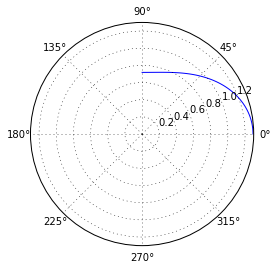

In [7]:
z_singularity = [0.75]
h0 = secant(residual, 1.26, 1.4, z_singularity)

H = numpy.zeros((2,Ntheta))
H[:, 0] = [h0, 0.0]

for i in range(Ntheta-1):
    H[:, i+1] = rk2_step(H[:, i], theta[i], dtheta, 
                         z_singularity)

pyplot.figure()
pyplot.polar(theta, H[0,:])
pyplot.show()

# Exercises

1. How does the solution vary with grid spacing and tolerance? What's the limiting factor? How do you check convergence?
2. Both initial value solvers and root finders are available in libraries. Look at Python versions. When is this a good approach? 